In [1]:
import numpy as np
import skimage as ski
import matplotlib.pyplot as plt
%matplotlib inline

# Shortest Path

In [2]:
def shortest_path(costs):
    """
    This function takes an array of costs and finds a shortest path from the 
    top to the bottom of the array which minimizes the total costs along the
    path. The path does not shift more than 1 location left or right between
    successive rows.
    
    In other words, the returned path is one that minimizes the total cost:
        
        total_cost = costs[0,path[0]] + costs[1,path[1]] + costs[2,path[2]] + ...

    subject to the constraint that:
    
        abs(path[i]-path[i+1])<=1
    
    Parameters
    ----------
    costs : 2D float array of shape HxW
         An array of cost values with W>=3
    
    Returns
    -------
    path : 1D array of length H
        indices of a vertical path.  path[i] contains the column index of 
        the path for each row i. 
    """

    nrows = costs.shape[0]
    ncols = costs.shape[1]
    
    # to keep the implementation simple, we will refuse to handle
    # the boundary case where the cost array is very narrow.
    assert(ncols>=3)
 
    # M[i,j] = cost of the lowest-cost seam that starts at at the top and ends up at pixel [i,j]
    M = np.zeros(costs.shape) # a.k.a "cost-to-go" array
    
    # to keep track of path indeces
    Q = np.zeros(costs.shape)
    
    # copy all row-0 entries from "costs" matrix
    M[0,:] = costs[0,:]
    
    # Add a column of np.inf at the end of matrix 'M'
    M = np.hstack([M, np.full((M.shape[0], 1), np.inf)])
   
    # compute "cost-to-go" values
    for i in range(1, nrows):
        for j in range(ncols):
            M[i,j] = costs[i,j] + np.min([M[i-1, j-1], M[i-1, j], M[i-1, j+1]])
            Q[i,j] = j - 1 + np.argmin([M[i-1, j-1], M[i-1, j], M[i-1, j+1]])
    
    # Convert entries of matrix 'Q' to integers
    Q = Q.astype(int)
    
    # backtrack to find shortest path
    path = [np.argmin(M[-1,:])] # index of lowest cost entry in the bottom row
    for i in range(nrows-1, 0, -1):
        path.append(Q[i, path[-1]])
    
    return np.array(path[::-1])

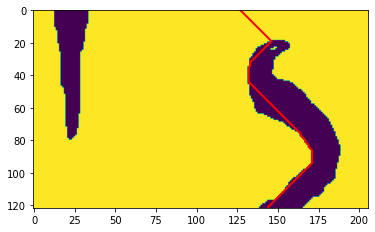

In [3]:
# Test for optimal seam
costs = plt.imread("path.png")
costs = np.mean(costs, 2)
path = shortest_path(costs)
plt.imshow(costs)
plt.plot(path, np.arange(costs.shape[0]), linewidth=2, color="red")
plt.show()

# Image Stitching

In [4]:
def stitch(left_image, right_image, overlap):
    """
    This function takes a pair of images with a specified overlap and stitches them
    togther by finding a minimal cost seam in the overlap region.
    
    Parameters
    ----------
    left_image : 2D float array of shape HxW1
        Left image to stitch 
    
    right_image : 2D float array of shape HxW2
        Right image to stitch 

    overlap : int
        Width of the overlap zone between left and right image
        
    Returns
    -------
    stitched : 2D float array of shape Hx(W1+W2-overlap)
        The resulting stitched image
    """
    
    # inputs should be the same height
    assert(left_image.shape[0]==right_image.shape[0])
    assert(overlap>=3)
    
    # extracts the overlapping strips and computes the absolute value of their difference
    left_strip = left_image[:, left_image.shape[1]-overlap:]
    right_strip = right_image[:, :overlap]
    overlap_diff = np.abs(left_strip - right_strip)
    
    seam = shortest_path(overlap_diff)
    
    # turns path into a binary (alpha) mask for each image 
    left_alpha_mask = np.zeros(overlap_diff.shape)
    right_alpha_mask = np.ones(overlap_diff.shape)
    for i in range(left_alpha_mask.shape[0]):
        left_alpha_mask[i, :seam[i]] = 1
        right_alpha_mask[i, :seam[i]] = 0
        # weights at the seam will be 1/2 for each image for blending
        left_alpha_mask[i, seam[i]] = 1/2
        right_alpha_mask[i, seam[i]] = 1/2
    
    # generates the output image by using pixels from the left image on the left side of the seam and from the right image on the right side of the seam.
    left_image = np.hstack([left_image[:, :left_image.shape[1]-overlap], left_image[:, left_image.shape[1]-overlap:] * left_alpha_mask])
    right_image = np.hstack([right_image[:, :overlap] * right_alpha_mask, right_image[:,overlap:]])
    
    stitched = np.zeros((left_image.shape[0], left_image.shape[1]+right_image.shape[1]-overlap))
    stitched[:, :left_image.shape[1]] = left_image
    stitched[:, left_image.shape[1]-overlap:] += right_image
    
    assert(stitched.shape[0]==left_image.shape[0])
    assert(stitched.shape[1]==(left_image.shape[1]+right_image.shape[1]-overlap))
    
    return stitched
    
    

# Texture Quilting

In [5]:
def synth_quilt(tile_map,tiledb,tilesize,overlap):
  
    """
    This function takes as input an array indicating the set of texture tiles 
    to use at each location, an array containing the database of available texture 
    tiles, tilesize and overlap parameters, and synthesizes the output texture by 
    stitching together the tiles

    
    Parameters
    ----------
    tile_map : 2D array of int
        Array storing the indices of which tiles to paste down at each output location 
    
    tiledb : 2D array of int 
        Collection of sample tiles to select from. The array is of size ntiles x npixels 
        where each tile image is stored in vectorized form as a row of the array.
        
    tilesize : (int,int)
        Size of a tile in pixels
        
    overlap : int
        Amount of overlap between tiles
        
    Returns
    -------
    output : 2D float array
        The resulting synthesized texture of size
    """
    
    # determine output size based on overlap and tile size
    outh = (tilesize[0]-overlap)*tile_map.shape[0] + overlap
    outw = (tilesize[1]-overlap)*tile_map.shape[1] + overlap
    output = np.zeros((outh,outw))
            
    # Stitches together all columns in each row
    for i in range(tile_map.shape[0]):
        icoord = i*(tilesize[0]-overlap)
        for j in range(tile_map.shape[1]-1):
            jcoord = j*(tilesize[1]-overlap)
            
            # Gets tile vectors from tiledb
            left_tile_vec = tiledb[tile_map[i,j],:]
            right_tile_vec = tiledb[tile_map[i,j+1],:]
            
            # Convert vector into a 2-D array
            left_tile_img = np.reshape(left_tile_vec,tilesize)
            right_tile_img = np.reshape(right_tile_vec,tilesize)
            
            # Stitch the two images together along the optimal seam
            stitched_tile = stitch(left_tile_img, right_tile_img, overlap)
            
            output[icoord:(icoord + tilesize[0]), jcoord:(jcoord + stitched_tile.shape[1])] = stitched_tile
        
    # Stitches together all rows
    for i in range(1, tile_map.shape[0]-1):
        icoord_prev = (i-1)*(tilesize[0]-overlap)
        icoord_cur = i*(tilesize[0]-overlap)
        icoord_next = (i+1)*(tilesize[0]-overlap)
        
        # Get consecutive rows and transpose them for vertical stitching
        left_img = output[icoord_prev:icoord_cur, :].T
        right_img = output[icoord_cur:icoord_next, :].T
        
        # Transpose stitched image to put back into the 'output' array
        stitched_img = stitch(left_img, right_img, overlap).T
        
        output[icoord_prev:icoord_next-overlap, :] = stitched_img

    
    return output


# Texture Synthesis Demo

In [6]:
def sample_tiles(image,tilesize,randomize=True):
    """
    This function generates a library of tiles of a specified size from a given source image
       
    Parameters
    ----------
    image : float array of shape HxW
        Input image 
            
    tilesize : (int,int)
        Dimensions of the tiles in pixels
        
        
    Returns
    -------
    tiles : float array of shape  numtiles x numpixels
        The library of tiles stored as vectors where npixels is the 
        product of the tile height and width     
    """
    
    tiles = ski.util.view_as_windows(image,tilesize)
    ntiles = tiles.shape[0]*tiles.shape[1]
    npix = tiles.shape[2]*tiles.shape[3]
    assert(npix==tilesize[0]*tilesize[1])
    
    print("library has ntiles = ",ntiles,"each with npix = ",npix)
    
    tiles = tiles.reshape((ntiles,npix)) 
    
    # randomize tile order
    if randomize:
        tiles = tiles[np.random.permutation(ntiles),:]
    
    return tiles


def topkmatch(tilestrip,dbstrips,k):
    """
    This function finds the top k candidate matches in dbstrips that
    are most similar to the provided tile strip.
      
    Parameters
    ----------
    tilestrip : 1D float array of length npixels
        Grayscale values of the query strip 
    
    dbstrips : 2D float array of size npixels x numtiles
        Array containing brightness values of numtiles strips in the database 
        to match to the npixels brightness values in tilestrip
                
    k : int
        Number of top candidate matches to sample from
        
    Returns
    -------
    matches : list of ints of length k
        The indices of the k top matching tiles   
    """
    assert(k>0)
    assert(dbstrips.shape[0]>k)
    error = (dbstrips-tilestrip)
    ssd = np.sum(error*error,axis=1)
    ind = np.argsort(ssd)
    matches = ind[0:k]
    return matches


def quilt_demo(sample_image, ntilesout=(10,20), tilesize=(30,30), overlap=5, k=5):
    """
    This function takes an image and quilting parameters and synthesizes a
    new texture image by stitching together sampled tiles from the source image.

     
    Parameters
    ----------
    sample_image : 2D float array
        Grayscale image containing sample texture 
    
    ntilesout : list of int
        Dimensions of output in tiles,  e.g. (3,4)
        
    tilesize : int
        Size of the square tile in pixels
        
    overlap : int
        Amount of overlap between tiles
        
    k : int
        Number of top candidate matches to sample from
        
    Returns
    -------
    img : list of int of length K
        The resulting synthesized texture of size           
    """
    
    # generate database of tiles from sample
    tiledb = sample_tiles(sample_image,tilesize)
    # number of tiles in the database
    nsampletiles = tiledb.shape[0]
    
    if (nsampletiles<k):
        print("Error: tile database is not big enough!")

    # generate indices of the different tile strips so we can easily
    # extract the left, right, top or bottom overlap strip from a tile
    i,j = np.mgrid[0:tilesize[0],0:tilesize[1]]
    top_ind = np.ravel_multi_index(np.where(i<overlap),tilesize)
    bottom_ind = np.ravel_multi_index(np.where(i>=tilesize[0]-overlap),tilesize)
    left_ind = np.ravel_multi_index(np.where(j<overlap),tilesize)
    right_ind = np.ravel_multi_index(np.where(j>=tilesize[1]-overlap),tilesize)

    # initialize an array to store which tile will be placed
    # in each location in the output image
    tile_map = np.zeros(ntilesout,'int')
    
#     print('row:')
    for i in range(ntilesout[0]):
#         print(i)
        for j in range(ntilesout[1]):
            
            if (i==0)&(j==0):                  # first row first tile
                matches = np.zeros(k) #range(nsampletiles)
            
            elif (i==0):                       # first row (but not first tile)
                left_tile = tile_map[i,j-1]
                tilestrip = tiledb[left_tile,right_ind]
                dbstrips = tiledb[:,left_ind]
                matches = topkmatch(tilestrip,dbstrips,k)
                
            elif (j==0):                       # first column (but not first row)
                above_tile = tile_map[i-1,j]
                tilestrip = tiledb[above_tile,bottom_ind]
                dbstrips = tiledb[:,top_ind] 
                matches = topkmatch(tilestrip,dbstrips,k)
                
            else:                              # neigbors above and to the left
                left_tile = tile_map[i,j-1]
                tilestrip_1 = tiledb[left_tile,right_ind]
                dbstrips_1 = tiledb[:,left_ind]
                above_tile = tile_map[i-1,j]
                tilestrip_2 = tiledb[above_tile,bottom_ind]
                dbstrips_2 = tiledb[:,top_ind]
                # concatenate the two strips
                tilestrip = np.concatenate((tilestrip_1,tilestrip_2))
                dbstrips = np.concatenate((dbstrips_1,dbstrips_2),axis=1)
                matches = topkmatch(tilestrip,dbstrips,k)
                
            #choose one of the k matches at random
            tile_map[i,j] = matches[np.random.randint(0,k)]
    
    output = synth_quilt(tile_map,tiledb,tilesize,overlap)
    
    return output


library has ntiles =  22801 each with npix =  2500
Source Image:


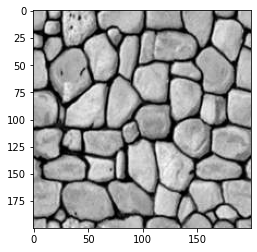

Synthesized texture:


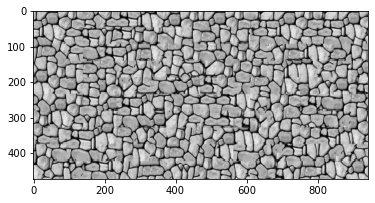

In [7]:
# Load image
test_img = plt.imread("rock_wall.jpg")

# convert image into grayscale
test_img = np.mean(test_img, 2)

output = quilt_demo(test_img, tilesize=(50,50), k = 3, overlap=3)

print("Source Image:")
plt.imshow(test_img, cmap=plt.cm.gray)
plt.show()
print("Synthesized texture:")
plt.imshow(output, cmap=plt.cm.gray)
plt.show()

library has ntiles =  27531 each with npix =  1200
Source Image:


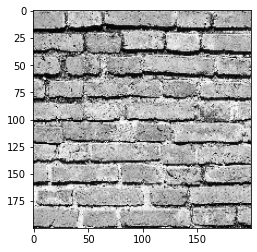

Synthesized texture:


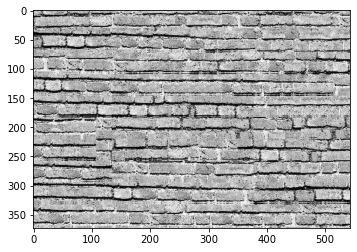

In [8]:
# Load image
test_img = plt.imread("brick_wall.png")

# convert image into grayscale
test_img = np.mean(test_img, 2)

output = quilt_demo(test_img, tilesize=(40,30), k = 5, overlap=3)

print("Source Image:")
plt.imshow(test_img, cmap=plt.cm.gray)
plt.show()
print("Synthesized texture:")
plt.imshow(output, cmap=plt.cm.gray)
plt.show()

library has ntiles =  29216 each with npix =  875
Source Image:


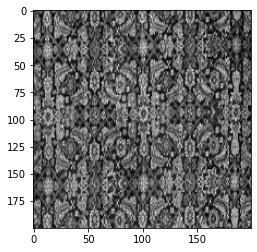

Synthesized texture:


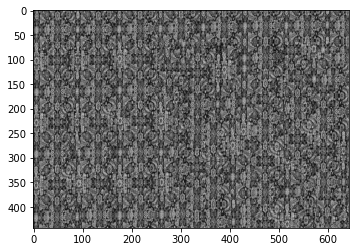

In [45]:
# Load image
test_img = plt.imread("rug.png")

# convert image into grayscale
test_img = np.mean(test_img, 2)

output = quilt_demo(test_img, ntilesout=(20,20), tilesize=(25,35), k = 1, overlap=3)

print("Source Image:")
plt.imshow(test_img, cmap=plt.cm.gray)
plt.show()
print("Synthesized texture:")
plt.imshow(output, cmap=plt.cm.gray)
plt.show()